## Chapter 7. Ensemble Learning and Random Forests
Suppose you pose a complex question to thousands of random people, then aggregate their answers. In many cases you will find that this aggregated answer is better than an expert’s answer. This is called the wisdom of the crowd. Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an ensemble; thus, this technique is called ensemble learning, and an ensemble learning algorithm is called an ensemble method.

As an example of an ensemble method, you can train a group of decision tree classifiers, each on a different random subset of the training set. You can then obtain the predictions of all the individual trees, and the class that gets the most votes is the ensemble’s prediction (see the last exercise in Chapter 6). Such an ensemble of decision trees is called a random forest, and despite its simplicity, this is one of the most powerful machine learning algorithms available today.

As discussed in Chapter 2, you will often use ensemble methods near the end of a project, once you have already built a few good predictors, to combine them into an even better predictor. In fact, the winning solutions in machine learning competitions often involve several ensemble methods—most famously in the Netflix Prize competition.

In this chapter we will examine the most popular ensemble methods, including voting classifiers, bagging and pasting ensembles, random forests, and boosting, and stacking ensembles.

# Voting Classifiers: The Wisdom of the Crowd

Imagine you've trained multiple machine learning models, each with reasonable accuracy (say, around 80%).  Examples could include logistic regression, SVMs, random forests, or k-nearest neighbors. Instead of relying on just one, a **voting classifier** combines their predictions for a final result.

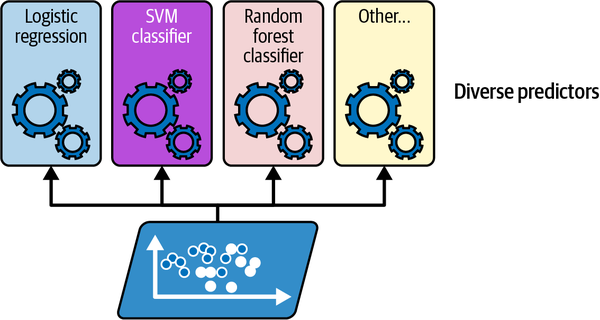

**training diverse classifiers**

## How Voting Classifiers Work

The core idea is to aggregate predictions from multiple models and choose the most popular one. This method often leads to better accuracy than any individual classifier could achieve on its own.

There are two main types of voting:

1.  **Hard Voting:**  Each classifier predicts a class label. The final prediction is the class that gets the most "votes" (most frequently predicted label).

    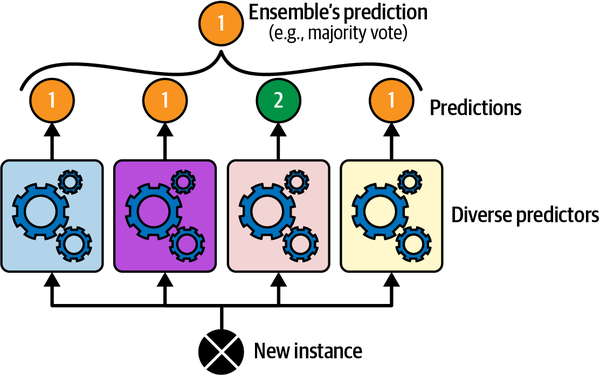

2.  **Soft Voting:** (Not in the original text, but worth mentioning) Each classifier predicts a *probability* for each class. These probabilities are averaged, and the class with the highest average probability is chosen as the final prediction.

## Why Voting Classifiers are Effective

The key to their success lies in the diversity of the individual classifiers.

*   **Error Reduction:** Individual models will make different mistakes.  By combining their predictions, these errors can cancel each other out, leading to more accurate results. Think of it as different perspectives on a problem converging to the right answer.

*   **Improved Generalization:** By not relying on a single model's "view" of the data, a voting classifier generalizes better to new, unseen data.

## The Coin Toss Analogy: Understanding the Math

The text uses an analogy of a biased coin to demonstrate the underlying principle:

*   **Slightly Biased Coin:** Imagine a coin that has a 51% chance of landing heads and a 49% chance of tails (like a slightly better than random classifier).
*   **Law of Large Numbers:** The law of large numbers states that as you repeat an experiment (coin tosses) multiple times the observed ratio will converge to the true probability.
*   **Majority Wins:** If you toss this coin many times, you're likely to get a majority of heads due to the 51% bias. For example with 1000 tosses, there is a 75% chance that a majority of tosses will be heads.

    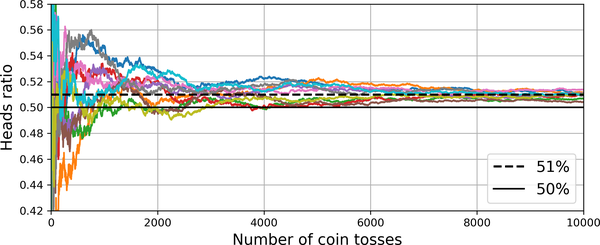

*   **Applying it to Models:** Similarly, if you have multiple models that are each slightly more accurate than random, their collective predictions using voting can achieve a much better performance.

## The Importance of Diversity

The effectiveness of a voting classifier depends heavily on how diverse the individual models are. 

*   **Independent Errors:** If models make the same mistakes, then the voting will not improve things significantly.
*   **Different Algorithms:** One way to achieve diversity is to use different machine learning algorithms (e.g., logistic regression, SVM, random forest).
*   **Different Datasets:** Another approach could be to train different algorithms on different datasets.

**In Conclusion:** Voting classifiers are a powerful and simple technique that can substantially improve the performance of a machine learning system by aggregating multiple models. The power lies in reducing the impact of individual model errors by combining the predictions from several diverse classifiers.

In [1]:
# sklearn provodes a VotingClassifier class 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.15, random_state=42)
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('Lr', LogisticRegression(random_state=42)), 
        ('Svc', SVC(random_state=42)), 
        ('rf', RandomForestClassifier(random_state=42))
        ]
)

voting_clf.fit(X_train_moons, y_train_moons)

VotingClassifier(estimators=[('Lr', LogisticRegression(random_state=42)),
                             ('Svc', SVC(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42))])

In [2]:
for name, est in voting_clf.named_estimators_.items():
    print(name, est.score(X_test_moons, y_test_moons))

# voting classifier clons the classifier, you can find the original classifier in estimators attribute

Lr 0.864
Svc 0.992
rf 0.992


In [3]:
voting_clf.predict(X_test_moons[:1]) # predict performs hard voting 

array([1], dtype=int64)

In [4]:
[clf_.predict(X_test_moons[:1]) for clf_ in voting_clf.estimators_]

[array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64)]

In [5]:
voting_clf.score(X_test_moons, y_test_moons) # score performs soft voting

0.984

- If all classifiers are able to estimate class probabilities (i.e., if they all have a predict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called soft voting. It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All you need to do is set the voting classifier’s voting hyperparameter to "soft", and ensure that all classifiers can estimate class probabilities. This is not the case for the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a predict_proba() method)

# Soft Voting vs. Hard Voting in Ensemble Learning

Ensemble learning combines the predictions of multiple models to achieve more robust and accurate results.  Two common methods for combining predictions are **hard voting** and **soft voting**.

## The Core Idea: Ensemble Learning

Instead of relying on a single model, we combine the "opinions" of several models. This is like getting recommendations from multiple friends instead of just one.

## How Predictions are Combined:

### 1. Hard Voting (Majority Voting)

*   **Mechanism:** Each model in the ensemble makes a discrete class prediction. The final prediction is the class that receives the majority of votes.
*   **Analogy:** A simple poll where each model casts a vote for one class. The class with the most votes wins.
*   **Implementation:**
    ```python
    import numpy as np

    def hard_voting(predictions):
        """
        Performs hard voting on a set of predictions.

        Args:
            predictions: A list of lists, where each inner list contains the
                predictions of a single model. (e.g., [['pos', 'neg'], ['pos', 'pos'], ['neg', 'neg']])

        Returns:
            A list of predicted classes based on majority vote.
        """
        predictions = np.array(predictions)
        final_predictions = []
        for example_idx in range(predictions.shape[1]): # for each example/row
            votes = predictions[:, example_idx] # grabs the class predictions from all models
            unique_classes, counts = np.unique(votes, return_counts=True) # gets unique class values and corresponding counts
            final_predictions.append(unique_classes[np.argmax(counts)]) # takes the class with the highest count
        return final_predictions
    
    # Example Usage:
    model1_predictions = ['positive', 'positive', 'negative']
    model2_predictions = ['positive', 'negative', 'negative']
    model3_predictions = ['negative', 'positive', 'positive']

    all_predictions = [model1_predictions, model2_predictions, model3_predictions]
    final_preds = hard_voting(all_predictions)
    print(f"Hard Voting Predictions: {final_preds}") # Output: ['positive', 'positive', 'negative']

    ```
*   **Key Characteristics:**
    *   Simple and easy to implement.
    *   Treats all model votes as equal, ignoring model confidence.
    *   Relies on clear, discrete class predictions.
    *   Can have issues with ties (need tie-breaker rule).
*   **When to Use:**
    *   When models are expected to be of similar performance.
    *   In straightforward classification problems.
    *   When simplicity is prioritized.

### 2. Soft Voting (Weighted Averaging)

*   **Mechanism:** Instead of using the final class prediction, soft voting uses the predicted *probabilities* or *confidence scores* from each model. These probabilities are averaged (or weighted) across all models, and the class with the highest *averaged* probability is chosen.
*   **Analogy:** Each model gives a percentage chance of "yes" and "no" and you calculate an average, to predict the final class.
*   **Implementation:**
    ```python
    import numpy as np

    def soft_voting(probabilities):
        """
        Performs soft voting on a set of predicted probabilities.

        Args:
            probabilities: A list of lists, where each inner list contains the
                 probabilities of each class for a single model. (e.g., [[0.7, 0.3], [0.6, 0.4], [0.4, 0.6]])

        Returns:
            A list of predicted classes based on averaged probabilities.
        """
        probabilities = np.array(probabilities)
        final_predictions = []
        for example_idx in range(probabilities.shape[1]): # iterate through each example/row
            probs = probabilities[:, example_idx] # grabs the probabilities from all models
            avg_prob = np.mean(probs, axis=0) # averages the probabilities for each class
            predicted_class = np.argmax(avg_prob) # chooses the class with the highest average probability
            final_predictions.append(predicted_class) # adds the class to the final list
        return final_predictions

    # Example Usage:
    model1_probs = [[0.7, 0.3], [0.6, 0.4], [0.3, 0.7]] # [positive, negative]
    model2_probs = [[0.6, 0.4], [0.5, 0.5], [0.2, 0.8]]
    model3_probs = [[0.4, 0.6], [0.7, 0.3], [0.7, 0.3]]
    
    all_probs = [model1_probs, model2_probs, model3_probs]
    final_preds = soft_voting(all_probs)
    print(f"Soft Voting Predictions (0=positive, 1=negative): {final_preds}") # Output: [0, 0, 1]

    ```
*   **Key Characteristics:**
    *   More nuanced than hard voting by considering confidence.
    *   Often performs better in practice.
    *   Requires models to output probabilities or confidence scores.
    *   Supports weighting of models based on performance.
*   **When to Use:**
    *   When models provide probability distributions.
    *   When models have varying performance.
    *   When higher accuracy is desired.

## Key Differences Summarized

| Feature          | Hard Voting                                | Soft Voting                                   |
|------------------|--------------------------------------------|-----------------------------------------------|
| **Aggregation**  | Majority class label                       | Averaged (or weighted) probabilities          |
| **Inputs**      | Discrete class labels                      | Probabilities or confidence scores           |
| **Confidence**  | Ignores model confidence                   | Considers model confidence                    |
| **Complexity**  | Simpler                                    | Slightly more complex                         |
| **Performance** | Typically less accurate                    | Typically more accurate                       |
| **Flexibility**| Less flexible                              | More flexible                                 |
| **Requirements**| Requires classification models              | Usually requires probabilistic models            |

## In Simple Terms

*   **Hard voting:** Everyone votes "yes" or "no", and we go with the majority.
*   **Soft voting:** Everyone gives a probability of "yes", and we average those probabilities to determine the final prediction.

## Which to Choose?

*   Use **hard voting** if your models only output class predictions.
*   Use **soft voting** if your models can provide probabilities or confidence scores, as it often leads to better performance.

## Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. Another approach is to use the same training algorithm for every predictor but train them on different random subsets of the training set. When sampling is performed with replacement,<sup>1</sup> this method is called **bagging**<sup>2</sup> (short for bootstrap aggregating<sup>3</sup>). When sampling is performed without replacement, it is called **pasting**<sup>4</sup>.

In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the *same* predictor. This sampling and training process is represented in Figure 7-4.

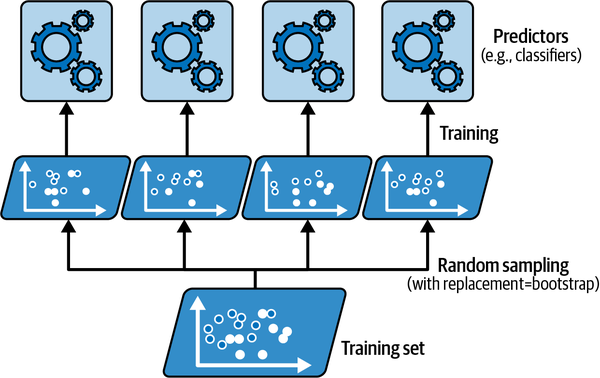

*Figure 7-4. Bagging and pasting involve training several predictors on different random samples of the training set*

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. The aggregation function is typically the statistical mode for classification (i.e., the most frequent prediction, just like with a hard voting classifier), or the average for regression. Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance.<sup>5</sup> Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.

As you can see in Figure 7-4, predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons bagging and pasting are such popular methods: they scale very well.

## Bagging and Pasting in Scikit-Learn

Scikit-Learn offers a simple API for both bagging and pasting: `BaggingClassifier` class (or `BaggingRegressor` for regression). The following code trains an ensemble of 500 decision tree classifiers:<sup>6</sup> each is trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set `bootstrap=False`). The `n_jobs` parameter tells Scikit-Learn the number of CPU cores to use for training and predictions, and `-1` tells Scikit-Learn to use all available cores:

```python
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), # the base estimator
    n_estimators=500,       # the number of trees in the ensemble
    max_samples=100,        # the number of samples for each model
    bootstrap=True,         # if True, bagging, if False, pasting
    n_jobs=-1              # use all available CPU cores
)
# Assuming you have X_train and y_train defined:
# bag_clf.fit(X_train, y_train)

Note
A BaggingClassifier automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a predict_proba() method), which is the case with decision tree classifiers.

Figure 7-5 compares the decision boundary of a single decision tree with the decision boundary of a bagging ensemble of 500 trees (from the preceding code), both trained on the moons dataset. As you can see, the ensemble’s predictions will likely generalize much better than the single decision tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular).

Bagging introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting; but the extra diversity also means that the predictors end up being less correlated, so the ensemble’s variance is reduced. Overall, bagging often results in better models, which explains why it’s generally preferred. But if you have spare time and CPU power, you can use cross-validation to evaluate both bagging and pasting and select the one that works best.

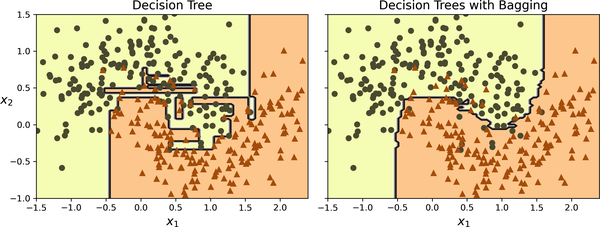

Figure 7-5. A single decision tree (left) versus a bagging ensemble of 500 trees (right)

## Out-of-Bag (OOB) Evaluation: A Free Performance Check with Bagging

### The Problem: We need to evaluate our model without using test data!
When training an ensemble using *bagging* (sampling with replacement), some training data points get picked multiple times, while others get missed entirely for a *single* model's training. We don't want to use our precious test data to validate the performance on this, which is where OOB comes into play!

### OOB to the Rescue!
*   **What is it?** During bagging, some data points won't be used to train a specific predictor. These unused data points are called **out-of-bag (OOB)** instances for that specific predictor.
*   **How Many?** On average, with bagging and data the same size as the training data, roughly 37% of the training data points will be OOB for any *one* predictor.
*   **Not the Same OOB:** It's critical to understand that *each* predictor will have a *different* set of OOB data points, since it is randomly sampled.

### Using OOB for Evaluation
Instead of needing a separate validation set, we can use the OOB data! Here's how:

1.  **Multiple Predictors:** Because we have multiple predictors (like 500 decision trees), each data point will likely be an OOB for *some* of the predictors in the ensemble.

2.  **OOB Predictions:** We use each of the predictors that didn't use a data point in their training to make a prediction for that specific data point.
     *   For example, If we had 3 predictors A, B, and C.  For the 1st datapoint predictor A may have used it, but B and C didn't, then we use B and C to predict its value. For the 2nd data point, A and B may have used it, but C didn't, so we use C to predict it etc.

3. **Aggregate to get final OOB prediction:** The final OOB prediction is then made, by aggregating the predictions of these predictors that used it as an OOB.
     *   The aggregation is typically done by using the most frequent prediction for classifications (just like hard voting) and the average for regression problems.
     *  This way, each data point will have a prediction from one or more predictors, that did not see them in training!

4.  **Compute Metrics:** Because each datapoint has its own OOB prediction now, we can then calculate the accuracy (or any other metric) over all datapoints using the OOB predictions of every data point.
    *  We are calculating the performance of the model on data it has never seen in training.

### OOB in Scikit-Learn
*   **`oob_score=True`:** In Scikit-Learn, when creating a `BaggingClassifier`, you can simply set `oob_score=True`.
*   **Automatic Evaluation:** After training, Scikit-Learn automatically does the OOB evaluation.
*   **Result:** The final OOB evaluation score is stored in the `.oob_score_` attribute.

### Code Example
```python
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification

# Sample data (replace with your actual data)
X, y = make_classification(n_samples=1000, random_state=42)


# Create a BaggingClassifier with OOB evaluation
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True # Enable OOB evaluation!
)

# Train the model
bag_clf.fit(X, y)

# Get the OOB score
oob_score = bag_clf.oob_score_
print(f"OOB Score: {oob_score}")

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train_moons, y_train_moons)
bag_clf.oob_score_

0.968

In [9]:
bag_clf.oob_decision_function_.shape, bag_clf.score(X_test_moons, y_test_moons)

((375, 2), 0.96)

In [8]:
bag_clf.oob_decision_function_[:10] # the probability of each class for each instance

array([[0.04166667, 0.95833333],
       [0.8856383 , 0.1143617 ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.00273224, 0.99726776],
       [0.        , 1.        ],
       [0.76214834, 0.23785166],
       [0.18133333, 0.81866667],
       [0.98927614, 0.01072386],
       [0.83291139, 0.16708861]])